In [1]:
import atoti as tt
import numpy as np
import pandas as pd

In [2]:
session = tt.create_session()

We convert the stock data into vector. Each value in the vector is a return that correspond to a date in the `returns` df.  
We load the stock with the vector of returns into atoti cube.

In [3]:
returns_table = session.read_csv(
    "returns.csv", keys=["stock"], store_name="Returns", array_sep=";"
)

returns_table.head()

,returns_vector
stock,
ATH,"doubleVector[369]{-0.005301677278131519, ...}"
CRUS,"doubleVector[369]{0.006378248610582457, ...}"
LUB,"doubleVector[369]{0.0, ...}"
EMB,"doubleVector[369]{0.002705492650867037, ...}"
DOV,"doubleVector[369]{-0.002853628488446275, ...}"


In [4]:
cube = session.create_cube(returns_table, "Return Cube")

In [5]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

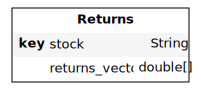

In [6]:
cube.schema

In [7]:
m

Measures()

The below formatter will allow us to visualize the first 5 values in each array.

In [8]:
m["returns_vector.MEAN"].formatter = "ARRAY['|';0:5]"
m["returns_vector.SUM"].formatter = "ARRAY['|';0:5]"

In [37]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Creating parameter hierarchy for dates
We extracted the dates from the `returns` df and create a parameter hierarchy with it.

In [10]:
calendar = pd.read_csv("dates.csv")["Date"]
calendar

0      2019-12-27
1      2019-12-30
2      2019-12-31
3      2020-01-02
4      2020-01-03
          ...    
364    2021-06-09
365    2021-06-10
366    2021-06-11
367    2021-06-14
368    2021-06-15
Name: Date, Length: 369, dtype: object

The parameter hierarchy allows us to have a `Date Index` measure that will be used to retrieve the correspond returns for the day.

In [11]:
cube.create_static_parameter_hierarchy(
    "Dates", list(calendar), index_measure="Date Index", store_name="Dates"
)
# Setting the hierarchy to non-slicing, as required by
# the max_member aggregation function - see later - this behavior might change in future versions.
h["Dates"].slicing = False

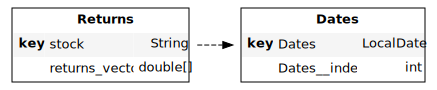

In [12]:
cube.schema

### Create random weight table

In [13]:
weight_table = session.create_store(
    types={"stock": tt.type.STRING, "weight": tt.type.NULLABLE_DOUBLE},
    store_name="Weight",
    keys=["stock"],
)

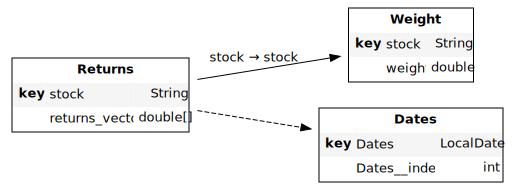

In [14]:
returns_table.join(weight_table)
cube.schema

### Creating the measure for weight

In [15]:
m["weight"] = tt.agg.sum(weight_table["weight"])
m["weight"].formatter = "DOUBLE[#,###.00000]"

### Creating function to generate random weight for a given portfolio

In [16]:
# it generates a random weight across the stocks, that sums up to 1
# creates a scenario for the given weights

def load_weights(scenario, selected_stocks):

    k = np.random.rand(len(selected_stocks))

    selected_stocks["weight"] = k / sum(k)
    selected_stocks.reset_index(inplace=True)

    # load data into atoti cube as a scenario
    weight_table.scenarios[scenario].load_pandas(selected_stocks[["stock", "weight"]])

### Creating the initial weight
Each call to the function will create a new scenario

In [17]:
# iterate the portfolio of n_stocks by n_weights (gives n_weights scenarios of different weight)
def generate_portfolios(n_stocks, n_weights):
    df_stocks = cube.query(m["contributors.COUNT"], levels=[l["stock"]])
    selected_stocks = df_stocks.sample(n_stocks).copy()

    for i in range(n_weights):
        load_weights(f"weight {i}", selected_stocks)

In [18]:
generate_portfolios(10, 3)

In [19]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Create sliding windows

Create a sliding window of size 252. This could be modified using a measure simulation if needed.

In [20]:
m["Lookback Window"] = 252

In [21]:
m["Returns sub-vector"] = m["returns_vector.SUM"][
    m["Date Index"] - m["Lookback Window"] + 1 : m["Date Index"] + 1
]

### Computing the mean of the array

In [22]:
m["p"] = tt.array.mean(m["returns_vector.SUM"])
m["p"].formatter = "DOUBLE[#,###.0000000000]"

The weighted average of the returns

In [23]:
m["p sliding"] = tt.agg.sum(
    tt.array.mean(m["weight"] * m["Returns sub-vector"]),
    scope=tt.scope.origin(l["stock"]),
)
m["p sliding"].formatter = "DOUBLE[#,###.0000000000]"

In [24]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Computing mu

In [25]:
m["mu"] = m["weight"] * m["p"]
m["mu"].formatter = "DOUBLE[#,###.00000]"

In [26]:
m["mu sliding"] = tt.agg.sum(
    m["weight"] * m["p sliding"], scope=tt.scope.origin(l["stock"])
)
m["mu sliding"].formatter = "DOUBLE[#,###.00000]"

### Computing Standard Deviation

We only compute the std for the stocks that has weights assigned.

In [27]:
m["Portfolio subvectors"] = tt.agg.sum(
    tt.where((m["weight"] > 0) & (m["weight"] < 1), m["Returns sub-vector"]),
    scope=tt.scope.origin(l["stock"]),
)

In [28]:
m["Std"] = tt.array.std(m["returns_vector.SUM"])
m["Std"].formatter = "DOUBLE[#,###.00000]"

In [29]:
m["std sliding"] = tt.array.std(m["Portfolio subvectors"])
m["std sliding"].formatter = "DOUBLE[#,###.00000]"

### Computing Sharpe Ratio

In [30]:
m["Sharpe Ratio"] = m["mu sliding"] / m["std sliding"]
m["Sharpe Ratio"].formatter = "DOUBLE[#,###.00000]"

In [31]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

Compute the maximum Sharpe Ratio for each Weight scenario

In [33]:
m["Max Sharpe Ratio"] = tt.where(
    m["Sharpe Ratio"] != None,
    tt.total(
        tt.agg.max(m["Sharpe Ratio"], scope=tt.scope.origin(l["Dates"])), h["Dates"]
    ),
)

m["Max Sharpe Ratio"].formatter = "DOUBLE[#,###.00000]"

In [34]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [35]:
m["Date max Sharpe"] = tt.agg.max_member(m["Sharpe Ratio"], l["Dates"])

Based on the max Sharpe Ratio, select the needed weight

In [36]:
session.visualize("Weight 0 simulation")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.